# Sprachidentifikation

### 1. Test der Qualität der Module mit Testdatensatz

Erstellen einer Konfusionsmatrix anhand des Testdatensatz

#### Modul langid

In [24]:
# === Formatdefinitionen ===
data_path = r"C:\Users\fabia\OneDrive - FHNW\03_FHNW\06_6_Semester\03_6000_BTh\91_NLP Unterlagen\language_detection\languages4.csv"
title_size = 18
subtitle_size = 14
axis_title_size = 12
axis_title_label_size = 12
legend_fontsize = 12

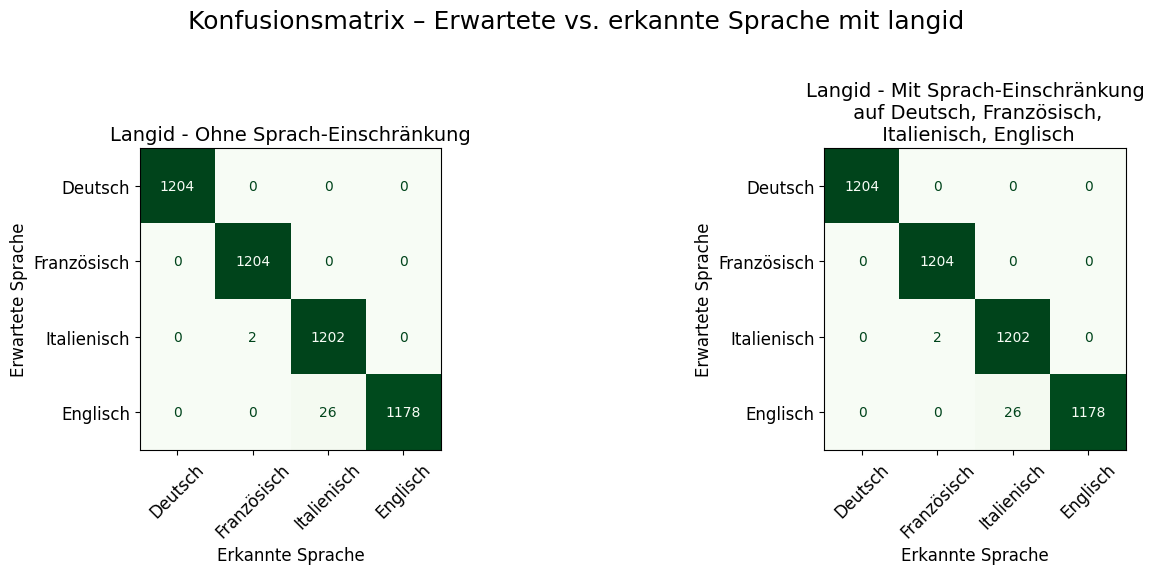

Gesamtgenauigkeit (mit Sprach-Einschränkung):     99.42 %
Gesamtgenauigkeit (ohne Sprach-Einschränkung):    99.42 %


In [68]:
import pandas as pd
import langid
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Sprachliste für die rechte Grafik (mit Constraint)
langid.set_languages(['en', 'fr', 'de', 'it'])

# Sprache erkennen – Variante mit Constraint
def detect_language_constrained(text):
    language_dict = {'en': 'Englisch', 'fr': 'Französisch', 'de': 'Deutsch', 'it': 'Italienisch'}
    try:
        lang, _ = langid.classify(str(text))
        return language_dict.get(lang, 'nicht_erkannt')
    except:
        return 'nicht_erkannt'

# Sprache erkennen – Variante ohne Constraint
def detect_language_unconstrained(text):
    language_dict = {'en': 'Englisch', 'fr': 'Französisch', 'de': 'Deutsch', 'it': 'Italienisch'}
    try:
        langid.set_languages(None)  # alle Sprachen zulassen
        lang, _ = langid.classify(str(text))
        return language_dict.get(lang, lang)  # zeige Original-Code, wenn unbekannt
    except:
        return 'nicht_erkannt'

# CSV einlesen
df = pd.read_csv(data_path, encoding="utf-8")

# Spalten definieren
base_columns = ['dataset_description']
languages = {'DE': 'Deutsch', 'FR': 'Französisch', 'IT': 'Italienisch', 'EN': 'Englisch'}

column_lang_mapping = {
    f"{base}_{lang}": expected_lang
    for base in base_columns
    for lang, expected_lang in languages.items()
    if f"{base}_{lang}" in df.columns
}

# Spracherkennung mit und ohne Constraint
for col, expected_lang in column_lang_mapping.items():
    df[f"{col}_constrained"] = df[col].apply(detect_language_constrained)
    df[f"{col}_unconstrained"] = df[col].apply(detect_language_unconstrained)

# Werte für beide Matrizen sammeln
detected_constrained = []
detected_unconstrained = []
expected = []

for col, lang in column_lang_mapping.items():
    detected_constrained += df[f"{col}_constrained"].tolist()
    detected_unconstrained += df[f"{col}_unconstrained"].tolist()
    expected += [lang] * len(df)

# Nur gültige Einträge filtern
def filter_valid(exp_list, det_list):
    return zip(*[(e, d) for e, d in zip(exp_list, det_list) if d != 'nicht_erkannt'])

expected_filtered_c, detected_filtered_c = filter_valid(expected, detected_constrained)
expected_filtered_u, detected_filtered_u = filter_valid(expected, detected_unconstrained)

# Labels (Deutsch)
labels = ['Deutsch', 'Französisch', 'Italienisch', 'Englisch']

# Konfusionsmatrizen
cm_c = confusion_matrix(expected_filtered_c, detected_filtered_c, labels=labels)
cm_u = confusion_matrix(expected_filtered_u, detected_filtered_u, labels=labels)

# Visualisierung
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

disp1 = ConfusionMatrixDisplay(confusion_matrix=cm_u, display_labels=labels)
disp1.plot(ax=axes[0], cmap='Greens', xticks_rotation=45, colorbar=False)
axes[0].set_title("Langid - Ohne Sprach-Einschränkung", fontsize=subtitle_size)
axes[0].set_xlabel("Erkannte Sprache", fontsize=axis_title_size)
axes[0].set_ylabel("Erwartete Sprache", fontsize=axis_title_size)
axes[0].tick_params(axis='both', labelsize=axis_title_label_size)

disp2 = ConfusionMatrixDisplay(confusion_matrix=cm_c, display_labels=labels)
disp2.plot(ax=axes[1], cmap='Greens', xticks_rotation=45, colorbar=False)
axes[1].set_title("Langid - Mit Sprach-Einschränkung\n auf Deutsch, Französisch,\n Italienisch, Englisch", fontsize=subtitle_size)
axes[1].set_xlabel("Erkannte Sprache", fontsize=axis_title_size)
axes[1].set_ylabel("Erwartete Sprache", fontsize=axis_title_size)
axes[1].tick_params(axis='both', labelsize=axis_title_label_size)

plt.suptitle("Konfusionsmatrix – Erwartete vs. erkannte Sprache mit langid", fontsize=title_size)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

# Genauigkeit berechnen
gesamt_genauigkeit_constrained = (sum(e == d for e, d in zip(expected, detected_constrained)) / len(expected)) * 100
gesamt_genauigkeit_unconstrained = (sum(e == d for e, d in zip(expected, detected_unconstrained)) / len(expected)) * 100

print(f"Gesamtgenauigkeit (mit Sprach-Einschränkung):     {gesamt_genauigkeit_constrained:.2f} %")
print(f"Gesamtgenauigkeit (ohne Sprach-Einschränkung):    {gesamt_genauigkeit_unconstrained:.2f} %")


#### Modul langdetect

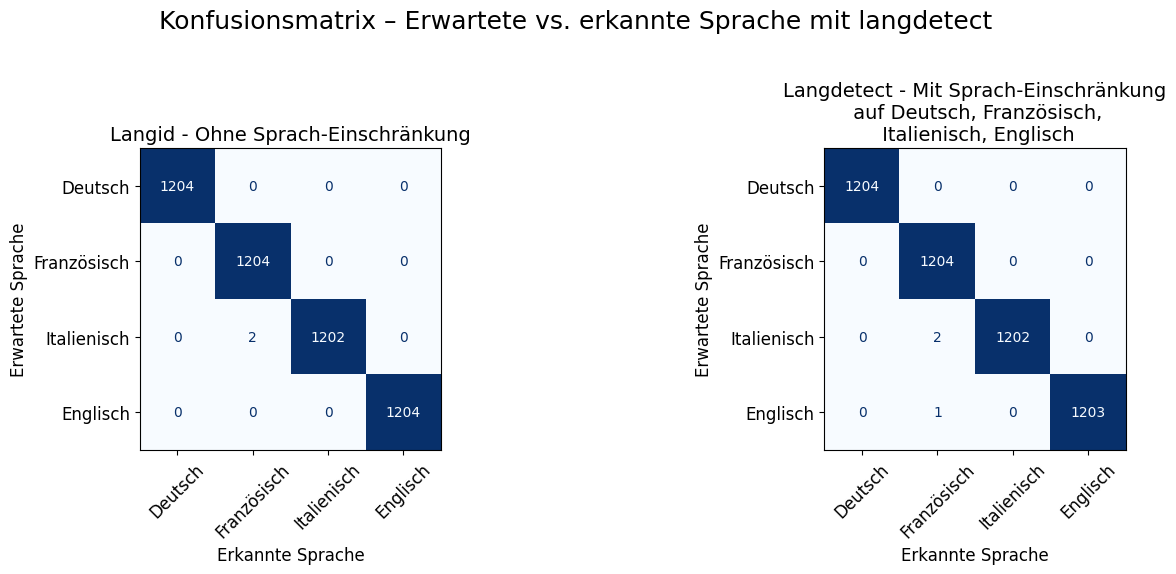

Gesamtgenauigkeit (mit Sprach-Einschränkung):     99.94 %
Gesamtgenauigkeit (ohne Sprach-Einschränkung):    99.96 %


In [69]:
import pandas as pd
import matplotlib.pyplot as plt
from langdetect import detect_langs
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# CSV einlesen
df = pd.read_csv(data_path, encoding="utf-8")

# Basisspalten und erwartete Sprachen
base_columns = ['dataset_description']
languages = {'DE': 'Deutsch', 'FR': 'Französisch', 'IT': 'Italienisch', 'EN': 'Englisch'}

column_lang_mapping = {
    f"{base}_{lang}": expected_lang
    for base in base_columns
    for lang, expected_lang in languages.items()
    if f"{base}_{lang}" in df.columns
}

# Mapping ISO → Deutsch
iso_to_de = {'en': 'Englisch', 'fr': 'Französisch', 'de': 'Deutsch', 'it': 'Italienisch'}

# Sprache erkennen mit Einschränkung – durchsucht alle Vorschläge
def detect_preferred_language(text, language_prefixes):
    try:
        langs = detect_langs(str(text))
        for lang in langs:
            if lang.lang in language_prefixes:
                return iso_to_de.get(lang.lang, 'nicht_erkannt')
        return 'nicht_erkannt'
    except:
        return 'nicht_erkannt'

# Sprache erkennen ohne Einschränkung (nimmt erste Sprache)
def detect_unconstrained(text):
    try:
        langs = detect_langs(str(text))
        return iso_to_de.get(langs[0].lang, langs[0].lang)
    except:
        return 'nicht_erkannt'

# Spracherkennung anwenden
for col, expected_lang in column_lang_mapping.items():
    df[f"{col}_constrained"] = df[col].apply(lambda x: detect_preferred_language(x, ['de', 'fr', 'it', 'en']))
    df[f"{col}_unconstrained"] = df[col].apply(detect_unconstrained)

# Vergleichslisten aufbauen
expected = []
detected_constrained = []
detected_unconstrained = []

for col, expected_lang in column_lang_mapping.items():
    expected += [expected_lang] * len(df)
    detected_constrained += df[f"{col}_constrained"].tolist()
    detected_unconstrained += df[f"{col}_unconstrained"].tolist()

# Nur gültige Einträge behalten
def filter_valid(e, d):
    return zip(*[(ex, de) for ex, de in zip(e, d) if de != 'nicht_erkannt'])

expected_c, detected_c = filter_valid(expected, detected_constrained)
expected_u, detected_u = filter_valid(expected, detected_unconstrained)

# Labels
labels = ['Deutsch', 'Französisch', 'Italienisch', 'Englisch']

# Konfusionsmatrizen
cm_c = confusion_matrix(expected_c, detected_c, labels=labels)
cm_u = confusion_matrix(expected_u, detected_u, labels=labels)

# Visualisierung
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Ohne Einschränkung
disp1 = ConfusionMatrixDisplay(confusion_matrix=cm_u, display_labels=labels)
disp1.plot(ax=axes[0], cmap='Blues', xticks_rotation=45, colorbar=False)
axes[0].set_title("Langid - Ohne Sprach-Einschränkung", fontsize=subtitle_size)
axes[0].set_xlabel("Erkannte Sprache", fontsize=axis_title_size)
axes[0].set_ylabel("Erwartete Sprache", fontsize=axis_title_size)
axes[0].tick_params(axis='both', labelsize=axis_title_label_size)

# Mit Einschränkung
disp2 = ConfusionMatrixDisplay(confusion_matrix=cm_c, display_labels=labels)
disp2.plot(ax=axes[1], cmap='Blues', xticks_rotation=45, colorbar=False)
axes[1].set_title("Langdetect - Mit Sprach-Einschränkung\n auf Deutsch, Französisch,\n Italienisch, Englisch", fontsize=subtitle_size)
axes[1].set_xlabel("Erkannte Sprache", fontsize=axis_title_size)
axes[1].set_ylabel("Erwartete Sprache", fontsize=axis_title_size)
axes[1].tick_params(axis='both', labelsize=axis_title_label_size)

# Gesamttitel
plt.suptitle("Konfusionsmatrix – Erwartete vs. erkannte Sprache mit langdetect", fontsize=title_size)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

# Genauigkeit berechnen
gesamt_genauigkeit_constrained = (sum(e == d for e, d in zip(expected, detected_constrained)) / len(expected)) * 100
gesamt_genauigkeit_unconstrained = (sum(e == d for e, d in zip(expected, detected_unconstrained)) / len(expected)) * 100

# Ausgabe
print(f"Gesamtgenauigkeit (mit Sprach-Einschränkung):     {gesamt_genauigkeit_constrained:.2f} %")
print(f"Gesamtgenauigkeit (ohne Sprach-Einschränkung):    {gesamt_genauigkeit_unconstrained:.2f} %")


### Anzahl Nötiger Zeichen feststellen

In [11]:
def run_language_detection_analysis(
    df,
    detect_language_func,
    base_columns=['dataset_description'],
    languages={'DE': 'german', 'FR': 'french', 'IT': 'italian', 'EN': 'english'},
    max_chars=100,
    min_chars=1,
    char_step=1
):
    """
    Führt eine Spracherkennungsanalyse für verschiedene Zeichenlängen durch.

    Parameter:
        df (pd.DataFrame): Eingabedaten.
        detect_language_func (function): Sprachdetektionsfunktion, gibt 'german', 'french' etc. zurück.
        base_columns (list): Liste von Basis-Spaltennamen (z. B. ['dataset_description']).
        languages (dict): Mapping von Sprachkürzeln zu erwarteten Sprachbezeichnungen.
        max_chars (int): Maximale Anzahl Zeichen für Test.
        min_chars (int): Minimale Anzahl Zeichen für Test.
        char_step (int): Schrittweite.

    Rückgabe:
        dict[str, pd.DataFrame]: Ergebnisse als DataFrames pro Sprache.
    """
    from tqdm import tqdm

    # Spalten aufbauen
    column_lang_mapping = {
        f"{base}_{lang}": expected_lang
        for base in base_columns
        for lang, expected_lang in languages.items()
        if f"{base}_{lang}" in df.columns
    }

    # Ergebnis-Container
    per_lang_results = {lang.capitalize(): [] for lang in languages.values()}
    char_range = range(max_chars, min_chars - 1, -char_step)

    # Hauptschleife
    for char_count in tqdm(char_range, desc="Zeichenlängen", unit="Zeichen"):
        for col, expected_lang in tqdm(column_lang_mapping.items(), desc=f"Spalten ({char_count} Zeichen)", leave=False):
            def cut_and_detect(text):
                if pd.isna(text) or not isinstance(text, str):
                    return 'not_found'
                short_text = text[:char_count]
                return detect_language_func(short_text)

            detected = df[col].apply(cut_and_detect)
            correct = (detected == expected_lang).sum()
            total = detected.count()
            accuracy = (correct / total) * 100 if total > 0 else 0
            per_lang_results[expected_lang.capitalize()].append((char_count, accuracy))

    # Rückgabe als DataFrames
    result_dfs = {
        lang: pd.DataFrame(results, columns=['Zeichenanzahl', 'Genauigkeit'])
        for lang, results in per_lang_results.items()
    }
    return result_dfs


In [12]:
import langid

lang_map = {'en': 'english', 'fr': 'french', 'de': 'german', 'it': 'italian'}

def make_langid_detector(constrained=True, allowed_langs=['en', 'fr', 'de', 'it']):
    if constrained:
        langid.set_languages(allowed_langs)
    else:
        langid.set_languages(None)

    def detect_language(text):
        try:
            lang, _ = langid.classify(text)
            return lang_map.get(lang, 'not_found')
        except:
            return 'not_found'

    return detect_language


In [13]:
from langdetect import detect_langs

iso_to_de = {
    'en': 'english', 'fr': 'french', 'de': 'german', 'it': 'italian'
}

def make_langdetect_detector(constrained=True, allowed_langs=['en', 'fr', 'de', 'it']):
    def detect_language(text):
        try:
            langs = detect_langs(str(text))
            if constrained:
                for lang in langs:
                    if lang.lang in allowed_langs:
                        return iso_to_de.get(lang.lang, 'not_found')
                return 'not_found'
            else:
                return iso_to_de.get(langs[0].lang, langs[0].lang)
        except:
            return 'not_found'

    return detect_language


In [14]:
# Detector factory mapping
detector_factories = {
    'langid': make_langid_detector,
    'langdetect': make_langdetect_detector
}

# Configurations: (model_name, constrained_flag)
configs = [
    ('langid', True),
    ('langid', False),
    ('langdetect', True),
    ('langdetect', False)
]

# Ergebnisse speichern
all_results = {}

# Loop über alle Kombinationen
for model_name, constrained in configs:
    detector_func = detector_factories[model_name](constrained=constrained)
    key = f"{model_name}_{'constrained' if constrained else 'unconstrained'}"
    all_results[key] = run_language_detection_analysis(df, detector_func)


Zeichenlängen:   0%|          | 0/100 [00:00<?, ?Zeichen/s]

Zeichenlängen: 100%|██████████| 100/100 [7:04:33<00:00, 254.74s/Zeichen]   


Grafik für langid und langdetect aufgeschlüsselt nach Sprache

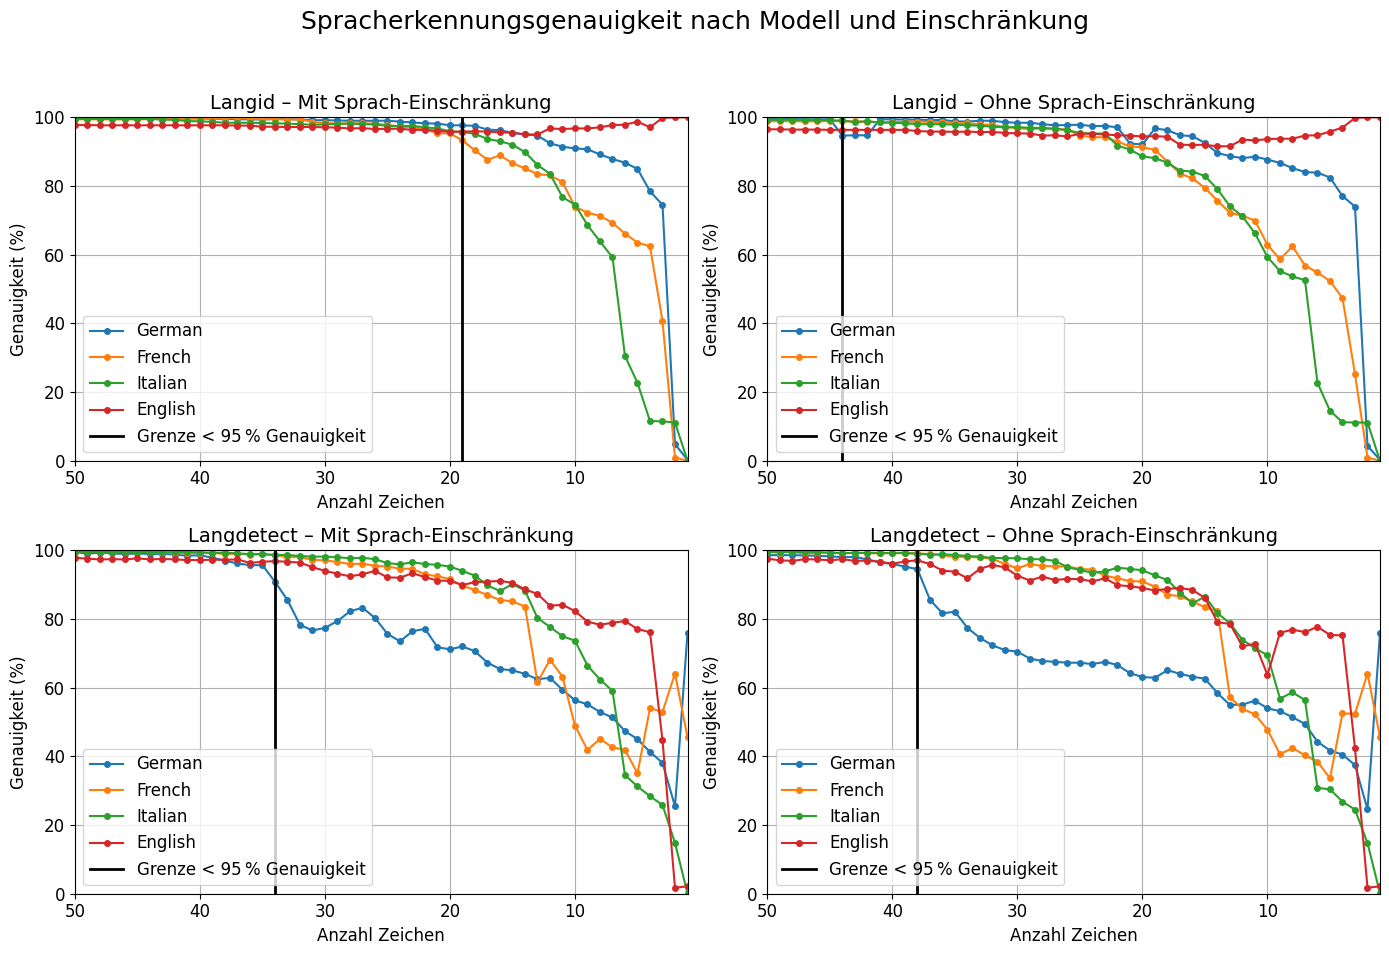

✔️ Zeichenanzahl, bei der die Genauigkeit erstmals unter 95 % fällt:

Langid – Mit Sprach-Einschränkung             ⟶ ab 19.0 Zeichen < 95 %
Langid – Ohne Sprach-Einschränkung            ⟶ ab 44.0 Zeichen < 95 %
Langdetect – Mit Sprach-Einschränkung         ⟶ ab 34.0 Zeichen < 95 %
Langdetect – Ohne Sprach-Einschränkung        ⟶ ab 38.0 Zeichen < 95 %


In [73]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle("Spracherkennungsgenauigkeit nach Modell und Einschränkung", fontsize=title_size)

# Reihenfolge der Kombinationen
sorted_keys = [
    'langid_constrained',
    'langid_unconstrained',
    'langdetect_constrained',
    'langdetect_unconstrained'
]

# Deutsche Titel
plot_titles = {
    'langid_constrained': 'Langid – Mit Sprach-Einschränkung',
    'langid_unconstrained': 'Langid – Ohne Sprach-Einschränkung',
    'langdetect_constrained': 'Langdetect – Mit Sprach-Einschränkung',
    'langdetect_unconstrained': 'Langdetect – Ohne Sprach-Einschränkung'
}

max_chars = 50
min_chars = 1

# Zeichnen
for ax, key in zip(axes.flat, sorted_keys):
    per_lang_results = all_results[key]
    all_char_accuracies = {}

    # Linien für jede Sprache zeichnen und Daten sammeln
    for lang, df_lang in per_lang_results.items():
        df_lang_sorted = df_lang.sort_values(by='Zeichenanzahl', ascending=False)
        ax.plot(
            df_lang_sorted['Zeichenanzahl'],
            df_lang_sorted['Genauigkeit'],
            marker='o',
             markersize=4,
            label=lang
        )
        # Merke dir Genauigkeit pro Zeichenanzahl
        for _, row in df_lang_sorted.iterrows():
            z = row['Zeichenanzahl']
            acc = row['Genauigkeit']
            all_char_accuracies.setdefault(z, []).append(acc)

    # Finde erste Zeichenanzahl, bei der mindestens eine Sprache < 95% ist
    for z in sorted(all_char_accuracies.keys(), reverse=True):
        if any(a < 95 for a in all_char_accuracies[z]):
            # Nur Linie mit Eintrag in der Legende, keine Beschriftung im Plot
            ax.plot([z, z], [0, 100], color='black', linestyle='-', linewidth=2, label='Grenze < 95 % Genauigkeit')
            break






    ax.set_title(plot_titles[key], fontsize=subtitle_size)
    ax.set_xlabel('Anzahl Zeichen', fontsize=axis_title_size)
    ax.set_ylabel('Genauigkeit (%)', fontsize=axis_title_size)
    ax.set_ylim(0, 100)
    ax.set_xlim(max_chars, min_chars)
    ax.grid(True)
    ax.tick_params(labelsize=axis_title_label_size)
    ax.legend(loc='lower left', fontsize=legend_fontsize)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

print("✔️ Zeichenanzahl, bei der die Genauigkeit erstmals unter 95 % fällt:\n")

for key in sorted_keys:
    per_lang_results = all_results[key]
    all_char_accuracies = {}

    # Genauigkeiten pro Zeichenanzahl sammeln
    for df_lang in per_lang_results.values():
        for _, row in df_lang.iterrows():
            z = row['Zeichenanzahl']
            acc = row['Genauigkeit']
            all_char_accuracies.setdefault(z, []).append(acc)

    # Nach absteigender Zeichenanzahl prüfen
    threshold_char = None
    for z in sorted(all_char_accuracies.keys(), reverse=True):
        if any(a < 95 for a in all_char_accuracies[z]):
            threshold_char = z
            break

    if threshold_char is not None:
        print(f"{plot_titles[key]:<45} ⟶ ab {threshold_char} Zeichen < 95 %")
    else:
        print(f"{plot_titles[key]:<45} ⟶ immer ≥ 95 %")



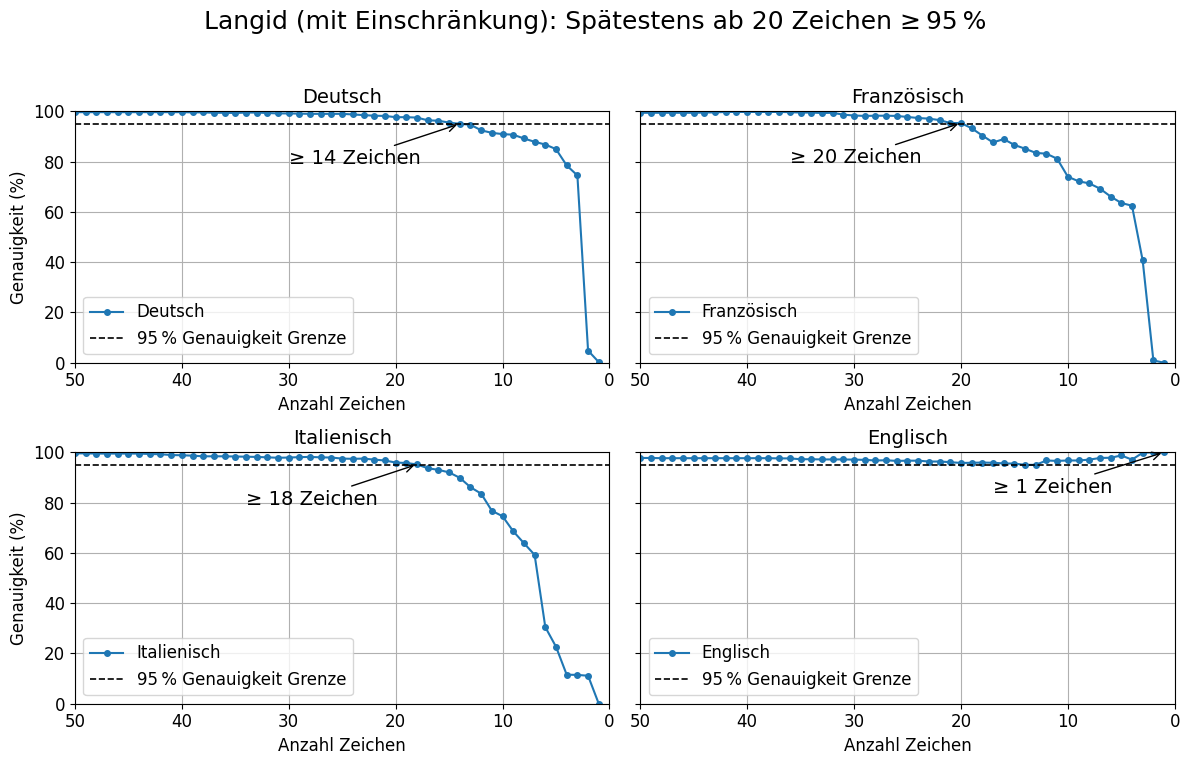

In [60]:
import matplotlib.pyplot as plt

# === Einstellungen ===
reliability_threshold = 95.0
display_min_chars = 0
display_max_chars = 50

# === Datenquelle: langid_constrained ===
per_lang_results = all_results["langid_constrained"]

# === Layout vorbereiten ===
n_langs = len(per_lang_results)
ncols = 2
nrows = (n_langs + 1) // ncols

fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(12, 4 * nrows), sharey=True)
axes = axes.flatten()

# Statistikspeicher
reliable_char_stats = []

# === Plot pro Sprache ===
for i, (lang, df_lang) in enumerate(per_lang_results.items()):
    ax = axes[i]

    # Sortieren und Filtern
    df_sorted = df_lang.sort_values(by='Zeichenanzahl', ascending=False)
    values_sorted = list(zip(df_sorted['Zeichenanzahl'], df_sorted['Genauigkeit']))

    # Plotbereich filtern
    filtered_values = [(c, a) for c, a in values_sorted if display_min_chars <= c <= display_max_chars]
    if not filtered_values:
        continue

    f_chars, f_accuracies = zip(*filtered_values)
    ax.plot(f_chars, f_accuracies, marker='o', markersize=4, label=lang_labels.get(lang, lang))

    # Schwellenlinie (95%)
    ax.axhline(y=reliability_threshold, color='black', linestyle='--', linewidth=1.2, label=f"95 % Genauigkeit Grenze")
    ax.legend(loc='lower left', fontsize=legend_fontsize)

    # Erster zuverlässiger Punkt (aus Gesamtdaten)
    reliable_point = next(((c, acc) for c, acc in reversed(values_sorted) if acc >= reliability_threshold), None)
    if reliable_point:
        char_count, acc = reliable_point
        reliable_char_stats.append((lang, char_count, round(acc, 2)))

        if display_min_chars <= char_count <= display_max_chars:
            ax.annotate(f'≥ {char_count} Zeichen',
                        xy=(char_count, acc),
                        xytext=(char_count + 16, acc - 16),
                        arrowprops=dict(arrowstyle='->', lw=1, color='black'),
                        fontsize=subtitle_size, color='black', ha='left')

    # Titel & Achsen
    lang_labels = {
        "German": "Deutsch",
        "French": "Französisch",
        "Italian": "Italienisch",
        "English": "Englisch"
    }
    ax.set_title(lang_labels.get(lang, lang), fontsize=subtitle_size)
    ax.set_xlabel('Anzahl Zeichen', fontsize=axis_title_size)
    if i % ncols == 0:
        ax.set_ylabel('Genauigkeit (%)', fontsize=axis_title_size)
    ax.tick_params(labelsize=axis_title_label_size)
    ax.set_xlim(display_max_chars, display_min_chars)
    ax.set_xticks(range(display_max_chars, display_min_chars - 1, -10))
    ax.set_ylim(0, 100)
    ax.grid(True)

# Leere Felder entfernen
if n_langs < len(axes):
    for j in range(n_langs, len(axes)):
        fig.delaxes(axes[j])

# Gesamtüberschrift
fig.suptitle(
    f"Langid (mit Einschränkung): Spätestens ab {max(c for _, c, _ in reliable_char_stats)} Zeichen ≥ 95 %",
    fontsize=title_size
)
fig.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


### Schlüsselwörter Erkennung

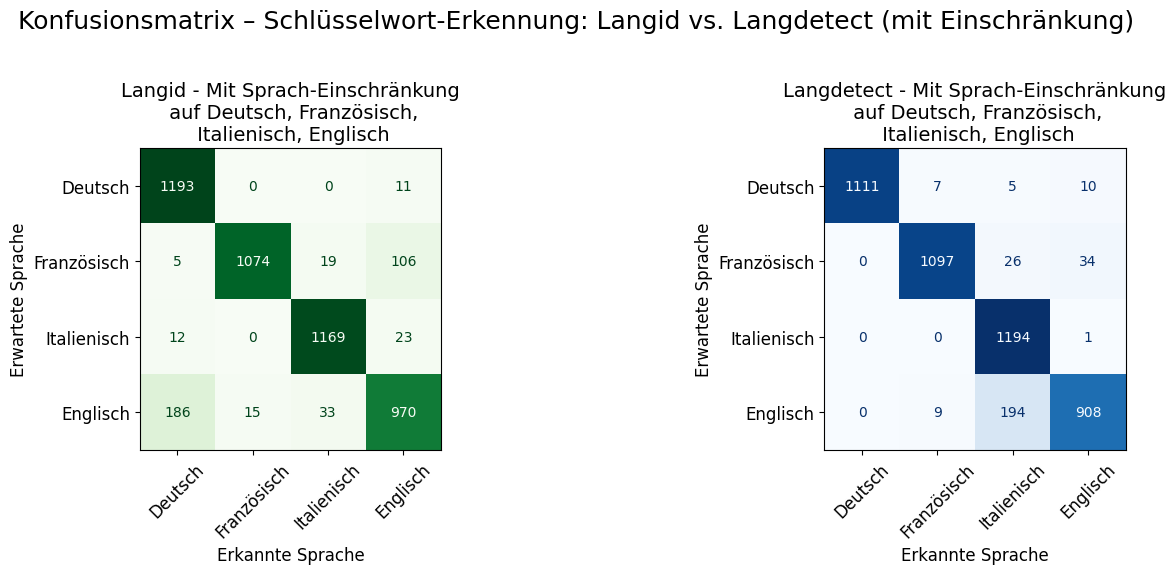

Langid (mit Einschränkung) Genauigkeit:     91.49 %
Langdetect (mit Einschränkung) Genauigkeit: 89.49 %


In [74]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import langid
from langdetect import detect_langs

# === Sprach-Mapping ===
languages = {'DE': 'Deutsch', 'FR': 'Französisch', 'IT': 'Italienisch', 'EN': 'Englisch'}
iso_to_de = {'en': 'Englisch', 'fr': 'Französisch', 'de': 'Deutsch', 'it': 'Italienisch'}


# === Sprachfunktionen ===
langid.set_languages(['en', 'fr', 'de', 'it'])

def detect_langid_constrained(text):
    try:
        lang, _ = langid.classify(str(text))
        return iso_to_de.get(lang, 'nicht_erkannt')
    except:
        return 'nicht_erkannt'

def detect_langdetect_constrained(text):
    try:
        langs = detect_langs(str(text))
        for lang in langs:
            if lang.lang in ['de', 'fr', 'it', 'en']:
                return iso_to_de.get(lang.lang, 'nicht_erkannt')
        return 'nicht_erkannt'
    except:
        return 'nicht_erkannt'

# === Daten einlesen ===
df = pd.read_csv(data_path, encoding="utf-8")

# === Spaltenzuordnung ===
base_columns = ['dataset_keyword']
column_lang_mapping = {
    f"{base}_{lang}": expected_lang
    for base in base_columns
    for lang, expected_lang in languages.items()
    if f"{base}_{lang}" in df.columns
}

# === Spracherkennung anwenden ===
for col, expected_lang in column_lang_mapping.items():
    df[f"{col}_langid_c"] = df[col].apply(detect_langid_constrained)
    df[f"{col}_langdetect_c"] = df[col].apply(detect_langdetect_constrained)

# === Ergebnisse sammeln ===
expected = []
detected_langid_c = []
detected_langdetect_c = []

for col, lang in column_lang_mapping.items():
    expected += [lang] * len(df)
    detected_langid_c += df[f"{col}_langid_c"].tolist()
    detected_langdetect_c += df[f"{col}_langdetect_c"].tolist()

# === Gültige Einträge filtern ===
def filter_valid(e, d):
    return zip(*[(ex, de) for ex, de in zip(e, d) if de != 'nicht_erkannt'])

expected_langid_c, detected_langid_c_f = filter_valid(expected, detected_langid_c)
expected_langdetect_c, detected_langdetect_c_f = filter_valid(expected, detected_langdetect_c)

# === Konfusionsmatrizen ===
labels = ['Deutsch', 'Französisch', 'Italienisch', 'Englisch']
cm_langid = confusion_matrix(expected_langid_c, detected_langid_c_f, labels=labels)
cm_langdetect = confusion_matrix(expected_langdetect_c, detected_langdetect_c_f, labels=labels)

# === Visualisierung (nebeneinander) ===
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Langid
disp1 = ConfusionMatrixDisplay(confusion_matrix=cm_langid, display_labels=labels)
disp1.plot(ax=axes[0], cmap='Greens', xticks_rotation=45, colorbar=False)
axes[0].set_title("Langid - Mit Sprach-Einschränkung\n auf Deutsch, Französisch,\n Italienisch, Englisch", fontsize=subtitle_size)
axes[0].set_xlabel("Erkannte Sprache", fontsize=axis_title_size)
axes[0].set_ylabel("Erwartete Sprache", fontsize=axis_title_size)
axes[0].tick_params(axis='both', labelsize=axis_title_label_size)

# Langdetect
disp2 = ConfusionMatrixDisplay(confusion_matrix=cm_langdetect, display_labels=labels)
disp2.plot(ax=axes[1], cmap='Blues', xticks_rotation=45, colorbar=False)
axes[1].set_title("Langdetect - Mit Sprach-Einschränkung\n auf Deutsch, Französisch,\n Italienisch, Englisch", fontsize=subtitle_size)
axes[1].set_xlabel("Erkannte Sprache", fontsize=axis_title_size)
axes[1].set_ylabel("Erwartete Sprache", fontsize=axis_title_size)
axes[1].tick_params(axis='both', labelsize=axis_title_label_size)

plt.suptitle("Konfusionsmatrix – Schlüsselwort-Erkennung: Langid vs. Langdetect (mit Einschränkung)", fontsize=title_size)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

# === Genauigkeit berechnen ===
acc_langid = (sum(e == d for e, d in zip(expected, detected_langid_c)) / len(expected)) * 100
acc_langdetect = (sum(e == d for e, d in zip(expected, detected_langdetect_c)) / len(expected)) * 100

print(f"Langid (mit Einschränkung) Genauigkeit:     {acc_langid:.2f} %")
print(f"Langdetect (mit Einschränkung) Genauigkeit: {acc_langdetect:.2f} %")

# === 10 englische Keywords, die fälschlich als Deutsch erkannt wurden ===
print("\n🔍 Stichwörter, die Englisch sein sollten, aber als Deutsch erkannt wurden (langid):\n")





In [83]:
# Nur falsch als Deutsch erkannte englische Keywords (langid)
false_english_as_german = []

for col, expected_lang in column_lang_mapping.items():
    if expected_lang == "Deutsch":  # Nur englische Spalten prüfen
        col_texts = df[col]
        col_detected = df[f"{col}_langid_c"]

        for original_text, detected_lang in zip(col_texts, col_detected):
            if detected_lang == "Englisch":
                false_english_as_german.append(original_text)

# Ausgabe
false_english_as_german = [kw for kw in false_english_as_german if isinstance(kw, str) and kw.strip() != ""]

print(len(false_english_as_german))
print("\n❌ Englisch erwartet, aber als Deutsch erkannt (langid):\n")
for kw in false_english_as_german:
    print(kw)


11

❌ Englisch erwartet, aber als Deutsch erkannt (langid):

['tourismus']
['tourismus']
['raum-und-umwelt', 'odin-open-data-inventory']
['raum-und-umwelt', 'odin-open-data-inventory']
['energie', 'odin-open-data-inventory', 'raum-und-umwelt']
['tourismus']
['tourismus']
['tourismus']
['tourismus']
['glam', 'openglam']
['video', '360', 'foto', 'mediathek', 'militar', 'vbs', 'themes']
